In [14]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt

import fiona
import shapely
import shapely.geometry
import geopandas as gpd

In [2]:
def distance(pt1, pt2):
    return math.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)

def get_side_lengths(shape):
    xs, ys = shape.boundary.xy
    pts = list(zip(xs, ys))
    lengths = []
    for i in range(len(pts)-1):
        lengths.append(distance(pts[i], pts[i+1]))
    assert len(lengths) == 4
    return sorted(lengths)

In [13]:
f = fiona.open("../data/testing_5_tifs.geojson","r")
side_lengths = []
areas = []
for row in f:
    if row["geometry"]["type"] == "Polygon":
        shape = shapely.geometry.shape(row["geometry"])
        areas.append(shape.area)
        num_points = len(row["geometry"]["coordinates"][0])
        if num_points == 5: # if the polygon is made up of 5 points then it is a rectangle and we can directly compute side lengths
            side_lengths.append(get_side_lengths(shape))
        else: # if the polygon is made up of different numbers of points then we use the minimum bounding rectangle
            side_lengths.append(get_side_lengths(shape.minimum_rotated_rectangle))
    else: # we have a MultiPolygon, run the above logic for each Polygon in the MultiPolygon
        for coordinates in row["geometry"]["coordinates"]:
            new_geom = {
                'type': 'Polygon',
                'coordinates': coordinates
            }
            shape = shapely.geometry.shape(new_geom)
            if shape.area > 100:
                side_lengths.append(get_side_lengths(shape.minimum_rotated_rectangle))
                areas.append(shape.area)
f.close()

side_lengths = np.array(side_lengths)

In [8]:
short_sides = side_lengths[:,:2].mean(axis=1)
long_sides = side_lengths[:,2:].mean(axis=1)

In [9]:
aspect_ratios = long_sides / short_sides

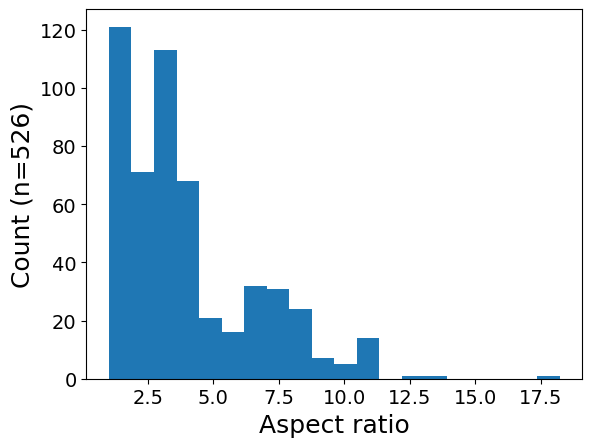

In [10]:
plt.figure()
plt.hist(long_sides / short_sides,bins=20)
plt.xlabel("Aspect ratio", fontsize=18)
plt.ylabel("Count (n=%d)" % (long_sides.shape[0]), fontsize=18)
#plt.title("Average %0.2f +/- %0.2f" % (aspect_rations.mean(), aspect_rations.std()), fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
plt.close()

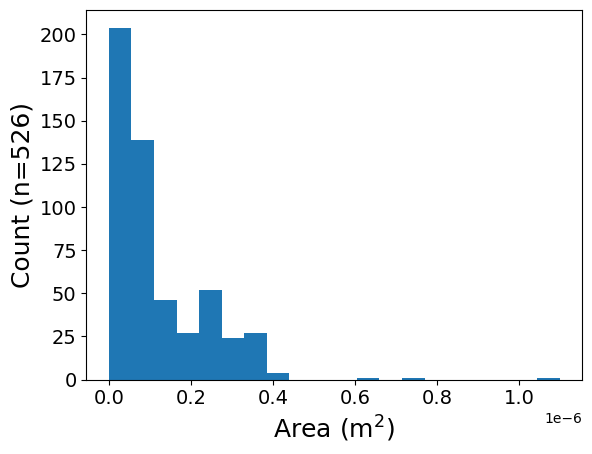

In [11]:
plt.figure()
plt.hist(areas,bins=20)
plt.xlabel("Area (m$^2$)", fontsize=18)
plt.ylabel("Count (n=%d)" % (long_sides.shape[0]), fontsize=18)
#plt.title("Average %0.2f +/- %0.2f" % (np.mean(areas), np.std(areas)), fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
plt.close()